<a href="https://colab.research.google.com/github/buthaina279/P4DS/blob/main/pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project mimic-351822 df
SELECT *
FROM mimic-351822.create_patient_cohort.last_cohort
order by subject_id

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math 
# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Modelling Helpers
from sklearn.preprocessing import  Normalizer , scale
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

import keras
from keras import backend as K

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [ ]:
df.shape

(43780, 77)

In [ ]:
df.columns

Index(['subject_id', 'icustay_id', 'hadm_id', 'gender', 'los_hospital', 'age',
       'ethnicity_grouped', 'hospstay_seq', 'first_hosp_stay', 'los_icu',
       'icustay_seq', 'first_icu_stay', 'height', 'weight', 'heartrate_min',
       'heartrate_max', 'heartrate_mean', 'sysbp_min', 'sysbp_max',
       'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min',
       'meanbp_max', 'meanbp_mean', 'resprate_min', 'resprate_max',
       'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean', 'spo2_min',
       'spo2_max', 'spo2_mean', 'aniongap_min', 'aniongap_max', 'albumin_min',
       'albumin_max', 'bands_min', 'bands_max', 'bicarbonate_min',
       'bicarbonate_max', 'bilirubin_min', 'bilirubin_max', 'creatinine_min',
       'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min',
       'glucose_max', 'hematocrit_min', 'hematocrit_max', 'hemoglobin_min',
       'hemoglobin_max', 'lactate_min', 'lactate_max', 'platelet_min',
       'platelet_max', 'potassium_min

Replace age 300 to be 90

In [ ]:
# Applying the condition
df.loc[df["age"] > 89, "age"] = 90

check the distribution

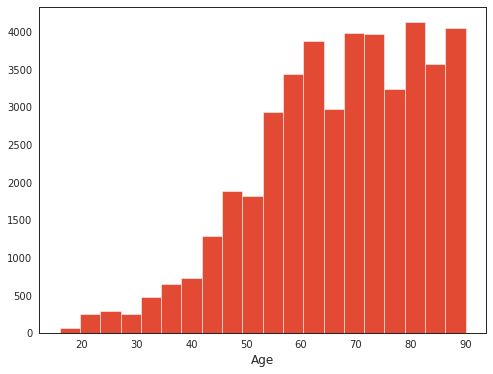

In [ ]:
plt.hist(df['age'], bins=20)
plt.xlabel('Age')
plt.show()

Drop IDs?

In [ ]:
df.drop(['subject_id', 'icustay_id', 'hadm_id'], axis=1, inplace=True)

In [ ]:
df.shape

(43780, 74)

##Correlation

correlation to the target

In [ ]:
corr_matrix=df.corr()
corr_matrix["mort_icu"].sort_values(ascending=False)

mort_icu        1.000000
lactate_max     0.271392
lactate_min     0.268252
aniongap_max    0.209531
aniongap_min    0.195870
                  ...   
albumin_max    -0.156309
meanbp_min     -0.166829
albumin_min    -0.174063
sysbp_min      -0.187155
spo2_min       -0.195485
Name: mort_icu, Length: 71, dtype: float64

**The top ten features with strongesr correlation to the target:**

the strogest correlated features are a combination between vital signs and labaratory 

In [ ]:
print("The top ten features with strongest correlations to the target:")
abs(corr_matrix["mort_icu"]).sort_values(ascending=False)[1:11]

The top ten features with strongest correlations to the target:


lactate_max      0.271392
lactate_min      0.268252
aniongap_max     0.209531
aniongap_min     0.195870
spo2_min         0.195485
sysbp_min        0.187155
albumin_min      0.174063
meanbp_min       0.166829
bun_min          0.159387
resprate_mean    0.158305
Name: mort_icu, dtype: float64

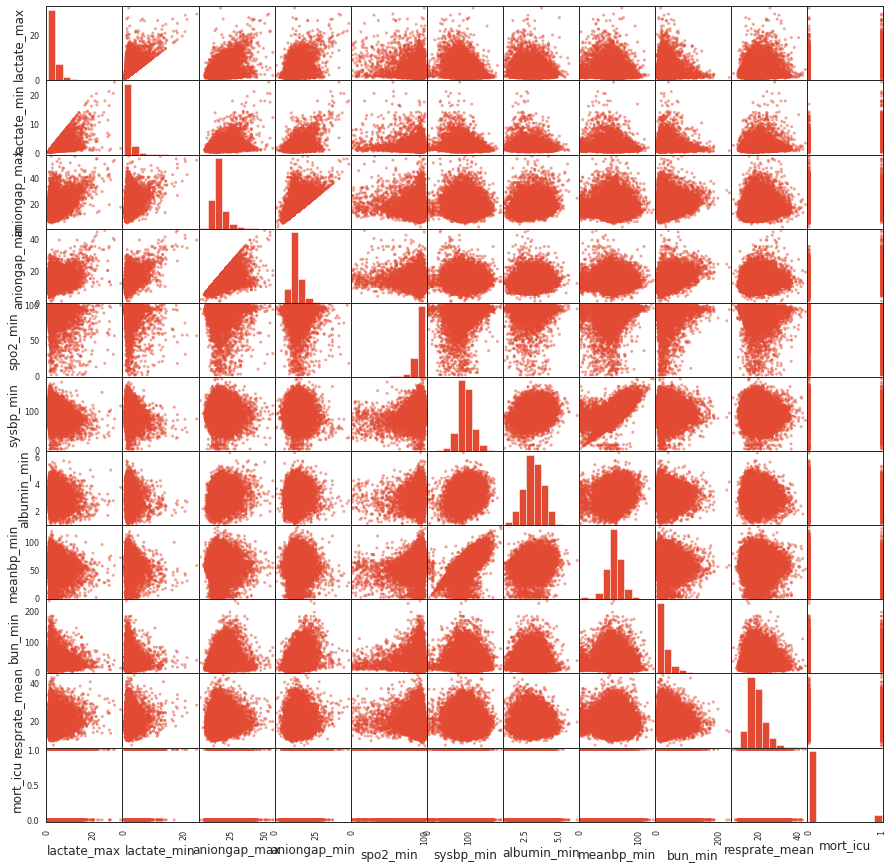

In [ ]:
from pandas.plotting import scatter_matrix


attributes=["lactate_max","lactate_min","aniongap_max","aniongap_min", "spo2_min", "sysbp_min"
, "albumin_min", "meanbp_min","bun_min", "resprate_mean", "mort_icu" ]



scatter_matrix(df[attributes], figsize=(25,25));



In [ ]:
print("The strength of the correlation between povertyPercent and PctPublicCoverageAlone: ",corr_matrix["lactate_max"]["lactate_min"])
print("The strength of the correlation between medIncome and povertyPercent: ",corr_matrix["lactate_max"]["aniongap_min"])
print("The strength of the correlation between PctBachDeg25_Over and target: ",corr_matrix["sysbp_min"]["meanbp_min"])

The strength of the correlation between povertyPercent and PctPublicCoverageAlone:  0.6434916375989918
The strength of the correlation between medIncome and povertyPercent:  0.297260226125845
The strength of the correlation between PctBachDeg25_Over and target:  0.694186200310518


###Missing values

In [ ]:
def missing(df):
        # Total missing values
        val = df.isnull().sum()
        
        # Percentage of missing values
        percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        table = pd.concat([val, percent], axis=1)
        
        # Rename the columns
        table_ren_columns = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        table_ren_columns = table_ren_columns[table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        # Return the dataframe with missing information
        return table_ren_columns

In [ ]:
#call missing function
import pandas as pd
missing(df)

,Missing Values,% of Total Values
ptt_min,4693,10.7
ptt_max,4693,10.7
pt_max,4528,10.3
pt_min,4528,10.3
inr_max,4528,10.3
inr_min,4528,10.3
urineoutput,2604,5.9
weight,1933,4.4
tempc_min,1222,2.8
tempc_max,1222,2.8


In [ ]:
limitPer = len(df) * .80
df = df.dropna(thresh=limitPer, axis=1)

In [ ]:
df.shape

(43780, 65)

In [ ]:
df.head()

,gender,los_hospital,age,ethnicity_grouped,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,weight,...,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,urineoutput,sapsii,LODS,mort_icu
0,M,11,76,white,1,True,6,1,True,96.8,...,136.0,153.0,41.0,53.0,11.3,24.4,497.0,79,10,0
1,F,16,66,white,1,True,4,1,True,None,...,134.0,138.0,62.0,65.0,10.6,10.6,1940.0,24,5,0
2,M,5,41,unknown,1,True,5,1,True,104,...,136.0,140.0,16.0,17.0,7.5,13.7,887.0,31,4,1
3,M,13,72,white,1,True,7,1,True,75,...,138.0,145.0,28.0,39.0,7.8,8.4,1425.0,41,5,0
4,F,7,40,white,1,True,4,1,True,73.5,...,137.0,140.0,13.0,18.0,16.6,19.3,1375.0,20,2,0


split the target from the dataframe

In [ ]:
target = df["mort_icu"]

In [ ]:
target.head()

0    0
1    0
2    1
3    0
4    0
Name: mort_icu, dtype: int64

In [ ]:
df.drop(['mort_icu'], axis=1, inplace=True)

In [ ]:
lods = df["LODS"]

In [ ]:
df.drop(['LODS'], axis=1, inplace=True)

In [ ]:
sapsii = df["sapsii"]

In [ ]:
df.drop(['sapsii'], axis=1, inplace=True)

In [ ]:
df.shape

(43780, 62)

In [ ]:
df.head()

,gender,los_hospital,age,ethnicity_grouped,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,weight,...,inr_max,pt_min,pt_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,urineoutput
0,M,11,76,white,1,True,6,1,True,96.8,...,1.7,13.5,15.7,136.0,153.0,41.0,53.0,11.3,24.4,497.0
1,F,16,66,white,1,True,4,1,True,None,...,1.4,12.6,14.6,134.0,138.0,62.0,65.0,10.6,10.6,1940.0
2,M,5,41,unknown,1,True,5,1,True,104,...,1.1,12.7,12.7,136.0,140.0,16.0,17.0,7.5,13.7,887.0
3,M,13,72,white,1,True,7,1,True,75,...,1.8,13.4,16.8,138.0,145.0,28.0,39.0,7.8,8.4,1425.0
4,F,7,40,white,1,True,4,1,True,73.5,...,1.8,13.3,16.5,137.0,140.0,13.0,18.0,16.6,19.3,1375.0


In [ ]:
df.columns

Index(['gender', 'los_hospital', 'age', 'ethnicity_grouped', 'hospstay_seq',
       'first_hosp_stay', 'los_icu', 'icustay_seq', 'first_icu_stay', 'weight',
       'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min',
       'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean',
       'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min',
       'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'spo2_min', 'spo2_max', 'spo2_mean', 'aniongap_min', 'aniongap_max',
       'bicarbonate_min', 'bicarbonate_max', 'creatinine_min',
       'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min',
       'glucose_max', 'hematocrit_min', 'hematocrit_max', 'hemoglobin_min',
       'hemoglobin_max', 'platelet_min', 'platelet_max', 'potassium_min',
       'potassium_max', 'ptt_min', 'ptt_max', 'inr_min', 'inr_max', 'pt_min',
       'pt_max', 'sodium_min', 'sodium_max', 'bun_min', 'bun_max', 'wbc_min',
       'wbc_max', 'urineoutput'

pre-processing the data using the pipeline

In [ ]:
from sklearn.base import BaseEstimator
class DataFrameSelector(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
cat_attribs = ['gender',
               'ethnicity_grouped',
               'first_hosp_stay',
               'first_icu_stay',   
               ]

In [ ]:
num_attribs = [ 'los_hospital',
        'age'
       , 'hospstay_seq',
       'los_icu', 
       'icustay_seq', 
       'weight', 
       'heartrate_min',
       'heartrate_max', 
       'heartrate_mean', 
       'sysbp_min', 
       'sysbp_max',
       'sysbp_mean', 
       'diasbp_min', 
       'diasbp_max', 
       'diasbp_mean', 
       'meanbp_min',
       'meanbp_max', 
       'meanbp_mean', 
       'resprate_min', 
       'resprate_max',
       'resprate_mean', 
       'tempc_min', 
       'tempc_max', 
       'tempc_mean', 
       'spo2_min',
       'spo2_max',
        'spo2_mean', 
        'aniongap_min', 
        'aniongap_max',
       'bicarbonate_min', 
       'bicarbonate_max',
        'creatinine_min',
       'creatinine_max', 
       'chloride_min',
        'chloride_max', 
        'glucose_min',
       'glucose_max', 
       'hematocrit_min',
        'hematocrit_max', 
        'hemoglobin_min',
       'hemoglobin_max',
        'platelet_min',
         'platelet_max', 
         'potassium_min',
       'potassium_max', 
       'ptt_min', 
       'ptt_max', 
       'inr_min', 
       'inr_max', 
       'pt_min',
       'pt_max', 
       'sodium_min', 
       'sodium_max',
        'bun_min', 
        'bun_max',
         'wbc_min',
       'wbc_max',
        'urineoutput']

In [ ]:
df["first_hosp_stay"]=df["first_hosp_stay"].astype("category")
df["first_icu_stay"]=df["first_icu_stay"].astype("category")

df_num=df[num_attribs]

# Create dataframe containing dummy versions for categorical variables in bd dataframe

df_cat=df[cat_attribs]
df_dum=pd.get_dummies(df_cat)

# Assemble numerical and one-hot encoded columns
df_num_dum=pd.concat([df_num, df_dum], axis=1)
df_num_dum.head()

,los_hospital,age,hospstay_seq,los_icu,icustay_seq,weight,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,...,ethnicity_grouped_black,ethnicity_grouped_hispanic,ethnicity_grouped_native,ethnicity_grouped_other,ethnicity_grouped_unknown,ethnicity_grouped_white,first_hosp_stay_False,first_hosp_stay_True,first_icu_stay_False,first_icu_stay_True
0,11,76,1,6,1,96.8,75.0,168.0,111.785714,64.0,...,0,0,0,0,0,1,0,1,0,1
1,16,66,1,4,1,None,76.0,100.0,84.160000,127.0,...,0,0,0,0,0,1,0,1,0,1
2,5,41,1,5,1,104,82.0,111.0,92.500000,106.0,...,0,0,0,0,1,0,0,1,0,1
3,13,72,1,7,1,75,71.0,105.0,85.828571,98.0,...,0,0,0,0,0,1,0,1,0,1
4,7,40,1,4,1,73.5,60.0,124.0,83.600000,102.0,...,0,0,0,0,0,1,0,1,0,1


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

num_pipeline = Pipeline([
    #('selector', DataFrameSelector(num_attribs)),
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler())
    #('std_scaler',MinMaxScaler())
])

df_prepared = num_pipeline.fit_transform(df_num_dum)

In [ ]:
# cat_pipeline = Pipeline([
#     ('selector',DataFrameSelector(cat_attribs)),
#     ('one hot',OneHotEncoder())
# ])

In [ ]:
# from sklearn.pipeline import FeatureUnion

# full_pipeline = FeatureUnion(transformer_list=[
#     ("num_pipeline",num_pipeline),
#     ("cat_pipeline",cat_pipeline)
# ])

In [ ]:
# df_prepared = full_pipeline.fit_transform(df)

In [ ]:
df_prepared

array([[-0.041989  ,  0.58512579, -0.31210583, ...,  0.55458836,
        -0.27562017,  0.27562017],
       [ 0.33216194, -0.06929574, -0.31210583, ...,  0.55458836,
        -0.27562017,  0.27562017],
       [-0.49097013, -1.70534954, -0.31210583, ...,  0.55458836,
        -0.27562017,  0.27562017],
       ...,
       [-0.64063051, -0.06929574, -0.31210583, ...,  0.55458836,
        -0.27562017,  0.27562017],
       [-0.64063051,  1.43587376, -0.31210583, ...,  0.55458836,
        -0.27562017,  0.27562017],
       [-0.49097013, -0.26562219, -0.31210583, ...,  0.55458836,
        -0.27562017,  0.27562017]])

In [ ]:
df_prepared.shape

(43780, 71)

In [ ]:
#X_train , X_test , y_train , y_test  = train_test_split(df_prepared , target , test_size = 0.2)
#print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [ ]:
#Instantiate Random Forest & logistic regression classifier instances (to be used for each dataset)
rf = RandomForestClassifier(n_estimators = 500, random_state = 1, n_jobs=-1, class_weight="balanced")
log = LogisticRegression(class_weight='balanced')
    #class_weight = "balanced" used to penalize mistakes on minority (deaths in hospital) class in proportion to under-representation



In [ ]:
#Function to evaluate model performance across metrics using 5-fold cross-validation
def print_accuracy_report(classifier, X, y, num_validations=5):
    auc = cross_val_score(classifier, X, y, scoring='roc_auc', cv=num_validations)
    print ("AUC (Mean->): " + str(round(100*auc.mean(), 2)) + "%" + " (Standard Deviation->): " + str(round(100*auc.std(), 2)) + "%")
    
    recall = cross_val_score(classifier, X, y, scoring='recall', cv=num_validations)
    print ("RECALL (Mean->): " + str(round(100*recall.mean(), 2)) + "%"+ " (Standard Deviation->): " + str(round(100*recall.std(), 2)) + "%")
    
    precision = cross_val_score(classifier, X, y, scoring='precision', cv=num_validations)
    print ("PRECISION (Mean->): " + str(round(100*precision.mean(), 2)) + "%"+ " (Standard Deviaton->): " + str(round(100*precision.std(), 2)) + "%")

    bal_acc = cross_val_score(classifier, X, y, scoring='balanced_accuracy', cv=num_validations)
    print ("BALANCED ACCURACY (Mean->): " + str(round(100*bal_acc.mean(), 2)) + "%"+ " (Standard Deviation->): " + str(round(100*bal_acc.std(), 2)) + "%")

In [ ]:
print_accuracy_report(rf, X_train, y_train) #Evaluate Random Forest model performance out-of-the box

AUC (Mean->): 92.25% (Standard Deviation->): 0.51%
RECALL (Mean->): 13.12% (Standard Deviation->): 0.81%
PRECISION (Mean->): 93.18% (Standard Deviaton->): 2.26%
BALANCED ACCURACY (Mean->): 56.52% (Standard Deviation->): 0.41%


In [ ]:
print_accuracy_report(log, df_prepared, target)#Evaluate Logistic Regression model performance out-of-the box

AUC (Mean->): 88.58% (Standard Deviation->): 0.83%
RECALL (Mean->): 79.56% (Standard Deviation->): 2.77%
PRECISION (Mean->): 29.76% (Standard Deviaton->): 1.67%
BALANCED ACCURACY (Mean->): 81.22% (Standard Deviation->): 0.77%


**Logistic regression model improvement**

In [ ]:
X_train , X_test , y_train , y_test  = train_test_split(df_prepared , target , test_size = 0.3)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(30646, 71) (13134, 71) (30646,) (13134,)


In [ ]:
#Evaluate L1 regularization strengths for reducing features in final model 
C = [10, 1, .1, 0.05,.01,.001] # As C decreases, more coefficients go to zero

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear', class_weight="balanced")
    clf.fit(X_train, y_train)
    pred_y=clf.predict(X_test) 
    print("Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE: ", c)
    cr=metrics.classification_report(y_test, pred_y)
    print(cr)
    print('')

Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE:  10
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     12048
           1       0.29      0.79      0.42      1086

    accuracy                           0.82     13134
   macro avg       0.63      0.81      0.66     13134
weighted avg       0.92      0.82      0.86     13134


Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE:  1
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     12048
           1       0.29      0.79      0.42      1086

    accuracy                           0.82     13134
   macro avg       0.63      0.81      0.66     13134
weighted avg       0.92      0.82      0.86     13134


Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE:  0.1
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     12048
 

**Build L1 model and calculate odds-ratios of features within L1 model**

In [ ]:
#Develop L1 Logistic Regression Model and evaluate performance using cross-validation
logl1=LogisticRegression(penalty='l1', C=0.05, solver='liblinear', class_weight="balanced")

print_accuracy_report(logl1, df_prepared, target) #Performance evaluation of L1 regularized logistic regression model

AUC (Mean->): 88.57% (Standard Deviation->): 0.8%
RECALL (Mean->): 79.64% (Standard Deviation->): 2.55%
PRECISION (Mean->): 29.77% (Standard Deviaton->): 1.64%
BALANCED ACCURACY (Mean->): 81.26% (Standard Deviation->): 0.75%


In [ ]:
# #Develop L1 Logistic Regression Model and evaluate performance using cross-validation
# logl1=LogisticRegression(penalty='l1', C=0.1, solver='liblinear', class_weight="balanced")

# print_accuracy_report(logl1,  df_prepared, target) #Performance evaluation of L1 regularized logistic regression model

In [ ]:
#Generate an L1 refined logistic regression model and list of features with coefficients/odds-ratios
logl1.fit(X_train, y_train)
pred_y=logl1.predict(X_test) 
probs_y=logl1.predict_proba(X_test)  

#Construct a dataframe of all features with their coefficients/odds-ratios from L1 model(logf)
coeff = pd.concat([pd.DataFrame(df_num_dum.columns),pd.DataFrame(np.transpose(logl1.coef_))], axis = 1)
coeff.columns=("features", "coefficients")
coeff["odds_ratio"]=np.exp(coeff.coefficients)

In [ ]:
#Select all features with non-zero odds-ratios
L1_feat=coeff[coeff["coefficients"] != 0] .sort_values("odds_ratio", ascending=False)
L1_feat.to_csv("L1_features.csv", index=False)  #Export features with their coefficients/odds-ratios to a csv file

In [ ]:
odds_ratio_f = L1_feat.loc[(L1_feat['odds_ratio']>1.25) | ( L1_feat['odds_ratio'] < 0.8) ]

In [ ]:
odds_ratio_list = odds_ratio_f['features'].tolist()
odds_ratio_list

['los_icu',
 'icustay_seq',
 'bun_min',
 'hematocrit_min',
 'sodium_max',
 'meanbp_mean',
 'heartrate_mean',
 'resprate_mean',
 'glucose_min',
 'hemoglobin_max',
 'hemoglobin_min',
 'bicarbonate_min',
 'chloride_min',
 'bun_max',
 'heartrate_min',
 'diasbp_mean',
 'urineoutput',
 'sysbp_min',
 'platelet_min',
 'los_hospital']

they are 20

In [ ]:
X_top18=df_num_dum[odds_ratio_list]
df_prepared18 = num_pipeline.fit_transform(X_top18)
X_train18 , X_test18 , y_train18 , y_test18  = train_test_split(df_prepared18 , target , test_size = 0.2)
print(X_train18.shape,X_test18.shape,y_train18.shape,y_test18.shape)

(35024, 20) (8756, 20) (35024,) (8756,)


you have to check why this hapenning

In [ ]:
#6D.1. Further refine final model by removing all features with odds-ratios between 1.25 and 0.8 (selected from L1_feat)
# selected_features=["bun_min", "gcs_median","Age","bil_median", "fio_median","ICUType_2.0", "gcs_change",
#                          "resp_max","hr_max","gcs_max","ICUType_3.0","tropi_change","temp_max","weight_max",
#                         "nidia_min","alt_change","weight_min","dia_min"]

 #Subset top18 features into a new preditor matrix

print_accuracy_report(logl1, df_prepared18, target) #Evaluate performance using subsetted top18 predictors (compared to 28 L1 predictors in Sectio 6C)

AUC (Mean->): 87.34% (Standard Deviation->): 0.74%
RECALL (Mean->): 78.43% (Standard Deviation->): 2.97%
PRECISION (Mean->): 28.04% (Standard Deviaton->): 1.68%
BALANCED ACCURACY (Mean->): 80.03% (Standard Deviation->): 0.69%


In [ ]:
#6D.2. Build "final" model based on top18 features from above and L1 regularization

#X_scaled18 = min_max_scaler.fit_transform(X_top18)#Scale features

#train_x18, test_x18, train_y, test_y = train_test_split(X_scaled18,y, stratify=y, test_size=0.3, random_state=2) #Generate a test-train split of data for model training and testing

logl1.fit(X_train18, y_train18) #fit final model 

pred_y18 = logl1.predict(X_test18) #store final model predictions 
probs_y18 = logl1.predict_proba(X_test18) #final model class probabilities 

In [ ]:
#Construct a dataframe of all features with their coefficients/odds-ratios from "final" model
coeff_final = pd.concat([pd.DataFrame(X_top18.columns),pd.DataFrame(np.transpose(logl1.coef_))], axis = 1)
coeff_final.columns=("features", "coefficients")
coeff_final["odds_ratio"]=np.exp(coeff_final.coefficients)

In [ ]:
coeff_final.head()

,features,coefficients,odds_ratio
0,los_icu,1.183406,3.265479
1,icustay_seq,0.583511,1.792321
2,bun_min,0.844378,2.326530
3,hematocrit_min,0.516712,1.676506
4,sodium_max,0.405909,1.500666


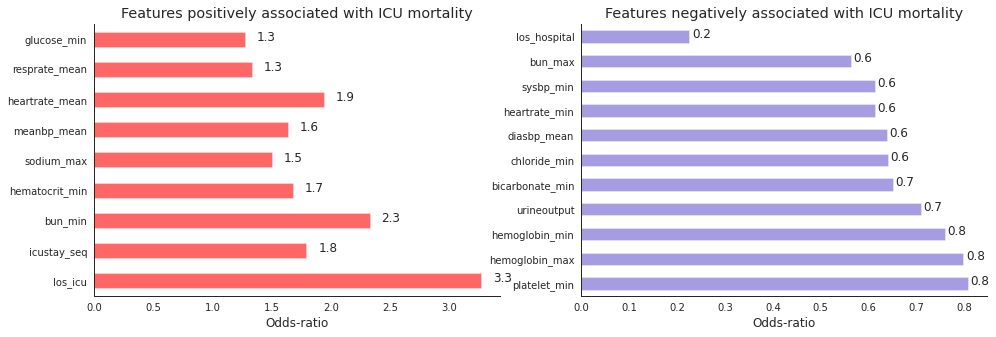

In [ ]:
#Generate dataframes of features with positive vs negative odds-ratios and plot
coeff_final.sort_values("odds_ratio", ascending=False)

coeff_pos=coeff_final[coeff_final["odds_ratio"]>1] #Generate dataframe of "positive" predictors 
coeff_pos_=coeff_pos.sort_values("odds_ratio", ascending=True)

coeff_neg=coeff_final[coeff_final["odds_ratio"]<=1]  #Generate dataframe of "negative" predictors of mortality
coeff_neg=coeff_neg.sort_values("odds_ratio", ascending=False)

#plot
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(16,5))
sns.set_style("white")


coeff_pos.plot(x="features", y="odds_ratio", kind="barh", legend=False, ax=ax1,color="red", alpha=0.6)
ax1.set_xlabel("Odds-ratio")
ax1.set_ylabel("")
ax1.set_title("Features positively associated with ICU mortality")
for i in ax1.patches:
    ax1.text(i.get_width()+.1, i.get_y()+.2,str(round((i.get_width()), 1)), fontsize=12)# attach values next to each bar in bar chart



coeff_neg.plot(x="features", y="odds_ratio", kind="barh", legend=False, ax=ax2, color="slateblue", alpha=0.6)
ax2.set_xlabel("Odds-ratio")
ax2.set_ylabel("")
ax2.set_title("Features negatively associated with ICU mortality")
for i in ax2.patches:
    ax2.text(i.get_width()+.005, i.get_y()+.2,str(round((i.get_width()), 1)), fontsize=12) # attach values next to each bar in bar chart

sns.despine()
plt.show();

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=5, shuffle = True, random_state = 999)



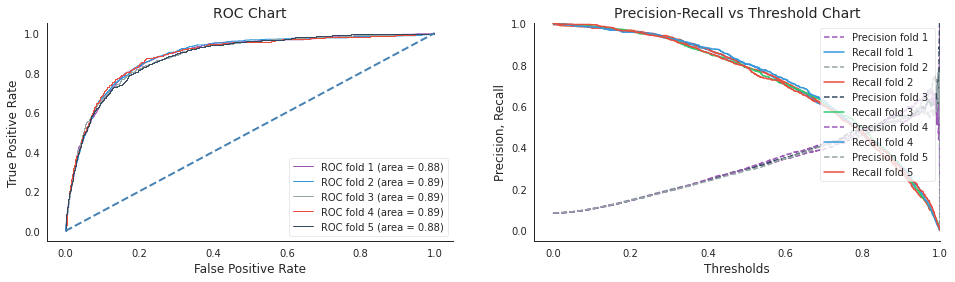

In [ ]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # set 5-color sns palette
sns.set_palette(flatui)
sns.set_style("white")

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121) # Plot ROC curve across multiple test-train splits

for i, (train_index, test_index) in enumerate(skf.split(df_prepared,target)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(df_prepared[train_index], target[train_index]).predict_proba(df_prepared[test_index])
    #Compute ROC curve for each test_train split
    fpr, tpr, thresholds = metrics.roc_curve(target[test_index], probas_[:,1])
    #Compute AUC for each test_train split
    roc_auc = metrics.auc(fpr, tpr)
    #Plot and add legend/title
    plt.plot(fpr, tpr, lw=1, label = "ROC fold %d (area = %0.2f)" % (i+1, roc_auc))
    plt.legend(loc='lower right')
    plt.title("ROC Chart", size = 14)
    
    
plt.plot([0,1], [0,1],'--',  lw = 2, color = "steelblue") # line for "random" guesses 

#Set graph axes, labels
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


axes = fig.add_subplot(122) # PLot Precision-Recall vs. (Probability) Threshold curve across multiple test-train splits

for i, (train_index, test_index) in enumerate(skf.split(df_prepared,target)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(df_prepared[train_index], target[train_index]).predict_proba(df_prepared[test_index])
    #Compute precision-recall curves for each test_train split 
    precision, recall, thresholds = metrics.precision_recall_curve(target[test_index], probas_[:,1]) #retrieve probability of being 1(in second column of probs_y)
    #Compute area under curve for each test_train split
    pr_auc = metrics.auc(recall, precision)
    #Plot and add legend/title
    plt.plot(thresholds, precision[: -1], "--", label = "Precision fold %d " % (i+1))
    plt.plot(thresholds, recall[: -1] ,"-", label = "Recall fold %d " % (i+1))
    
    plt.legend(loc='left')
    
    plt.title("Precision-Recall vs Threshold Chart", size = 14)

#Set graph axes, labels
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.0])

plt.ylabel("Precision, Recall")
plt.xlabel("Thresholds")

sns.despine()
plt.show();

with severity illness scores

In [ ]:
odds_ratio_list

['los_icu',
 'icustay_seq',
 'bun_min',
 'hematocrit_min',
 'sodium_max',
 'meanbp_mean',
 'heartrate_mean',
 'resprate_mean',
 'glucose_min',
 'hemoglobin_max',
 'hemoglobin_min',
 'bicarbonate_min',
 'chloride_min',
 'bun_max',
 'heartrate_min',
 'diasbp_mean',
 'urineoutput',
 'sysbp_min',
 'platelet_min',
 'los_hospital']

In [ ]:
##Current model predictors
# top18=["bun_min", "gcs_median","Age","bil_median", "fio_median","ICUType_2.0", "gcs_change",
#                          "resp_max","hr_max","gcs_max","ICUType_3.0","tropi_change","temp_max","weight_max",
#                         "nidia_min","alt_change","weight_min","dia_min"]
X_top18=df_num_dum[odds_ratio_list]
df_prepared18 = num_pipeline.fit_transform(X_top18)

#X_top18=xy1[top18] #Subset top18 features into a new preditor matrix

#X_top18_scaled = min_max_scaler.fit_transform(X_top18) #min-max scale predictors


##SOFA and SAPS-1 score model predictors (current predictors/benchmark)

#just lods
lods=["LODS"]
X_lods=df[lods]
df_lods = num_pipeline.fit_transform(X_lods)

#just sapsii
sapsii=["sapsii"]
X_sapsii=df[sapsii]
df_sapsii = num_pipeline.fit_transform(X_sapsii)
# all lods and sapsii
lods_sapsii=["sapsii", "LODS"]
X_lods_sapsii=df[lods_sapsii]
df_lods_sapsii = num_pipeline.fit_transform(X_lods_sapsii)

# ss=["SAPS-I", "SOFA"]
# X_ss=xy1[ss]
# X_ss_scaled = min_max_scaler.fit_transform(X_ss)


##Current model predictors + benchmark predictors
cmbp = ['los_icu',
 'icustay_seq',
 'bun_min',
 'hematocrit_min',
 'sodium_max',
 'meanbp_mean',
 'heartrate_mean',
 'resprate_mean',
 'glucose_min',
 'hemoglobin_max',
 'hemoglobin_min',
 'bicarbonate_min',
 'chloride_min',
 'bun_max',
 'heartrate_min',
 'diasbp_mean',
 'urineoutput',
 'sysbp_min',
 'platelet_min',
 'los_hospital',
 'LODS',
 'sapsii']

X_cmbp=df[cmbp]
df_lods_sapsii_18 = num_pipeline.fit_transform(X_cmbp)

##Adding length of stay as yet another predictor

# top18_LOS=["bun_min", "gcs_median","Age","bil_median", "fio_median","ICUType_2.0", "gcs_change",
#                          "resp_max","hr_max","gcs_max","ICUType_3.0","tropi_change","temp_max","weight_max",
#                         "nidia_min","alt_change","weight_min","dia_min", "Length_of_stay"]

# X_top18LOS=xy1[top18_LOS] #Subset top18 features into a new preditor matrix

# X_top18LOS_scaled = min_max_scaler.fit_transform(X_top18LOS) #min-max scale predictors



In [ ]:
print("Current logistic regression model with top 18 predictors")
print_accuracy_report(logl1, df_prepared18, target)
print("\n")

print("Logistic regression model with SOFA and SAPS-1 scores")
print_accuracy_report(logl1, df_lods, target)
print("\n")

print("Combined logistic regression model with top18 predictors and SAPS-1/SOFA scores")
print_accuracy_report(logl1,  df_sapsii, target)
print("\n")

print("Combined logistic regression model with top18 predictors and Length of Stay")
print_accuracy_report(logl1, df_lods_sapsii, target)
print("\n")


print("Combined logistic regression model with top18 predictors and Length of Stay")
print_accuracy_report(logl1, df_lods_sapsii_18, target)
print("\n")



Current logistic regression model with top 18 predictors
AUC (Mean->): 87.34% (Standard Deviation->): 0.74%
RECALL (Mean->): 78.43% (Standard Deviation->): 2.97%
PRECISION (Mean->): 28.04% (Standard Deviaton->): 1.68%
BALANCED ACCURACY (Mean->): 80.03% (Standard Deviation->): 0.69%


Logistic regression model with SOFA and SAPS-1 scores
AUC (Mean->): 76.04% (Standard Deviation->): 0.67%
RECALL (Mean->): 63.79% (Standard Deviation->): 2.25%
PRECISION (Mean->): 19.39% (Standard Deviaton->): 0.4%
BALANCED ACCURACY (Mean->): 69.89% (Standard Deviation->): 0.81%


Combined logistic regression model with top18 predictors and SAPS-1/SOFA scores
AUC (Mean->): 80.31% (Standard Deviation->): 0.8%
RECALL (Mean->): 70.72% (Standard Deviation->): 1.48%
PRECISION (Mean->): 20.82% (Standard Deviaton->): 0.45%
BALANCED ACCURACY (Mean->): 73.18% (Standard Deviation->): 0.72%


Combined logistic regression model with top18 predictors and Length of Stay
AUC (Mean->): 80.34% (Standard Deviation->): 0.68%


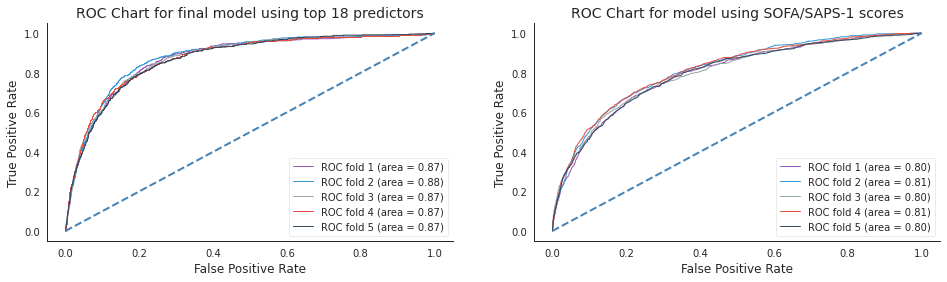

In [ ]:
#ROC chart comparison of "final" model in this study vs a logistic regression model using SAPS-I and SOFA scores used as a benchmark

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # set 5-color sns palette
sns.set_palette(flatui)
sns.set_style("white")

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121) # Plot ROC curve across multiple test-train splits

for i, (train_index, test_index) in enumerate(skf.split(df_prepared18,target)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(df_prepared18[train_index], target[train_index]).predict_proba(df_prepared18[test_index])
    #Compute ROC curve for each test_train split
    fpr, tpr, thresholds = metrics.roc_curve(target[test_index], probas_[:,1])
    #Compute AUC for each test_train split
    roc_auc = metrics.auc(fpr, tpr)
    #Plot and add legend/title
    plt.plot(fpr, tpr, lw=1, label = "ROC fold %d (area = %0.2f)" % (i+1, roc_auc))
    plt.legend(loc='lower right')
    plt.title("ROC Chart for final model using top 18 predictors", size = 14)
    
    
plt.plot([0,1], [0,1],'--',  lw = 2, color = "steelblue") # line for "random" guesses 

#Set graph axes, labels
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


axes = fig.add_subplot(122) # PLot ROC cuve across multiple test-train splits using SAPS-1 and SOFA scores

for i, (train_index, test_index) in enumerate(skf.split(df_lods_sapsii,target)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(df_lods_sapsii[train_index], target[train_index]).predict_proba(df_lods_sapsii[test_index])
    #Compute ROC curve for each test_train split
    fpr, tpr, thresholds = metrics.roc_curve(target[test_index], probas_[:,1])
    #Compute AUC for each test_train split
    roc_auc = metrics.auc(fpr, tpr)
    #Plot and add legend/title
    plt.plot(fpr, tpr, lw=1, label = "ROC fold %d (area = %0.2f)" % (i+1, roc_auc))
    plt.legend(loc='lower right')
    plt.title("ROC Chart for model using SOFA/SAPS-1 scores", size = 14)

plt.plot([0,1], [0,1],'--',  lw = 2, color = "steelblue") # line for "random" guesses 

#Set graph axes, labels
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


sns.despine()
plt.show();

Try deep learning

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout , BatchNormalization
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam

ImportError: ignored